In [1]:
import numpy as np
import pandas as pd

# the Bayesian stuff
import bambi as bmb
import pymc as pm
import pytensor.tensor as pt

# plotting
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# RNG
rng = np.random.default_rng(seed=20240704)

## Example 3: Modeling air and soil temperatures on Svalbard

Let's move on to an example with real data (finally!).

We will use a station data from the Bayelva station near Ny-Ålesund, Svalbard ([Grünberg et al. 2024](https://doi.org/10.1594/PANGAEA.969342), [Boike et al. 2018](https://essd.copernicus.org/articles/10/355/2018/)).

The data provided here are a subset of the meterological and soil variables for the years 1999-2022.

In [2]:
import os.path, requests

datafile = os.path.join("..", "data", "Bayelva_LTO_lv2_1999-2022.csv")
# download file if not available
if not os.path.isfile(datafile):
    r = requests.get("https://nextcloud.awi.de/s/Rg2krRSg8Y42kND/download/Bayelva_LTO_lv2_1999-2022.csv", stream=True)
    with open(datafile, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [3]:
bayelva_dataset = pd.read_csv(datafile)
bayelva_dataset["UTC"] = pd.to_datetime(bayelva_dataset["UTC"])
bayelva_dataset = bayelva_dataset.set_index("UTC")
bayelva_dataset.describe()

,Tair_degC_200cm,RH_percent_200cm,prec_mm/hour,snowdepth_m,RadNet_W/m2,Tsoil_degC_3cm,VWC_m3/m3_3cm
count,199790.000000,185380.000000,195219.000000,176959.000000,199021.000000,198740.000000,176026.000000
mean,-4.217781,79.798462,0.034956,0.418416,4.977135,-1.334803,0.106777
std,8.484430,11.532096,0.245242,0.360099,65.514785,5.502911,0.076466
min,-33.385000,34.070000,0.000000,-0.091000,-294.550000,-18.382000,-0.005000
25%,-10.346000,71.780000,0.000000,0.023000,-34.480000,-4.776000,0.059700
50%,-2.868500,80.090000,0.000000,0.410000,-6.900000,-1.586000,0.074900
75%,2.653750,88.330000,0.000000,0.713000,17.310000,0.476000,0.147000
max,17.565000,101.860000,23.100000,1.563000,529.670000,20.500000,0.444600


### Trend analysis

We'll start with a simple trend analysis. First we resample the data to annual scale.

In [4]:
# apply sum for precipitation but mean for everything else
agg_ops = {c: "sum" if c.startswith('prec') else "mean" for c in bayelva_dataset.columns}
bayelva_dataset_annual = bayelva_dataset.resample("1YE").agg(agg_ops)
# rename columns for convenience
bayelva_dataset_annual = bayelva_dataset_annual.rename({"Tair_degC_200cm": "Tair", "Tsoil_degC_3cm": "Tsoil"}, axis=1)
# drop years with a large number of missing data points;
# this is for example purposes only, see Grünberg et al. 2024 for a more thorough analysis.
bayelva_dataset_annual[bayelva_dataset.resample("1YE").count() < 335*24] = np.nan
# then add years as a covariate
bayelva_dataset_annual["year"] = bayelva_dataset_annual.index.year

Now let's specify the model using [bambi](https://bambinos.github.io/bambi/), a convenient wrapper around pymc that simplifies the specification of linear models.

In [5]:
Tair_trend_model = bmb.Model("Tair ~ 1 + year", bayelva_dataset_annual, family="t", dropna=True)

The basic model specification syntax is similar to other tools in python and R.

`1 + year` indicates a constant intercept plus a linear effect on the year.

We choose the likelihood to be a t-distribution with `family="t"` to make the trend analysis more robust to outliers.

Bambi provides a nice utility function to inspect the model priors!

Sampling: [Intercept, Tair_nu, Tair_sigma, year]


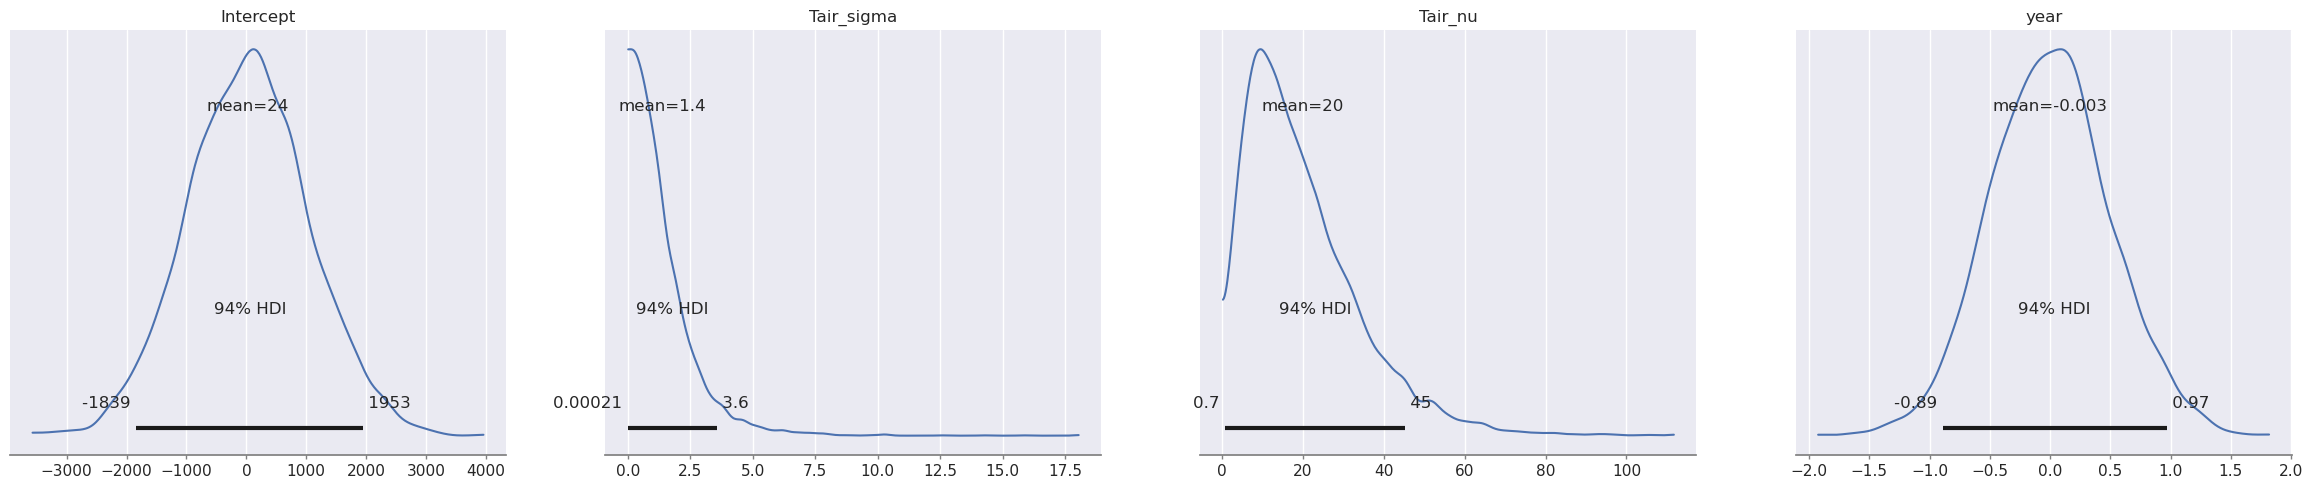

In [6]:
# we can also plot the priors 
Tair_trend_model.build()
Tair_trend_model.plot_priors();

Note the parameter `Tair_nu` is the degrees of freedom of the Student-t distribution. Larger values imply greater normality.

Now let's fit the model. Like pymc, bambi defaults to using NUTS for inference.

In [7]:
trend_idata = Tair_trend_model.fit(draws=1000, random_seed=1234);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tair_sigma, Tair_nu, Intercept, year]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


We can use `az.summary` to compute summary statistics about the Markov chains for each parameter.

The diagnostic quantities "effective sample size" (ESS) and $\hat{R}$ are important for assessing convergence.

In [8]:
az.summary(trend_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-165.169,78.131,-317.936,-20.171,1.393,1.011,3300.0,2364.0,1.0
Tair_nu,18.337,13.468,1.300,42.723,0.244,0.173,2069.0,1649.0,1.0
Tair_sigma,1.235,0.245,0.795,1.704,0.006,0.004,1753.0,1459.0,1.0
year,0.080,0.039,0.008,0.156,0.001,0.001,3302.0,2364.0,1.0


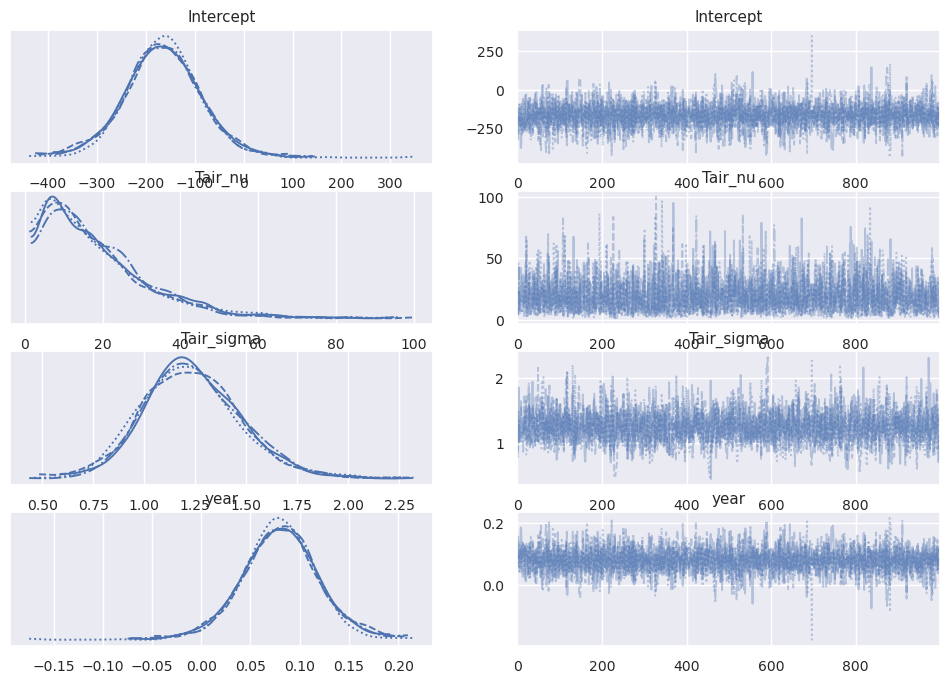

In [9]:
az.plot_trace(trend_idata);

One of the key benefits of Bayesian statistical analysis is that the samples from the posterior have a straightforward probabilistic interpretation.

We can very flexibly compute any expectation over these samples and interpret the results accordingly.

In [10]:
prob_trend = (trend_idata.posterior.year > 0.0).mean()
print("{0:.1f}% probability that air temperature trend > 0".format(prob_trend.values*100))

97.7% probability that air temperature trend > 0


Here is an alternative visualization of the posterior trend estimates using the `plot_forest` function from ArviZ.

Note the right panel

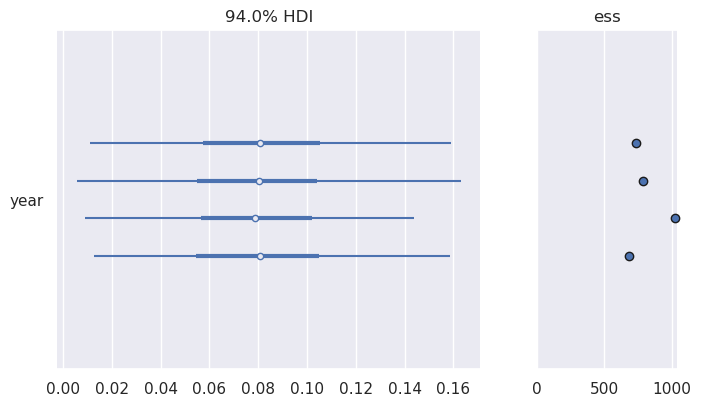

In [11]:
az.plot_forest(trend_idata, var_names=["year"], ess=True);

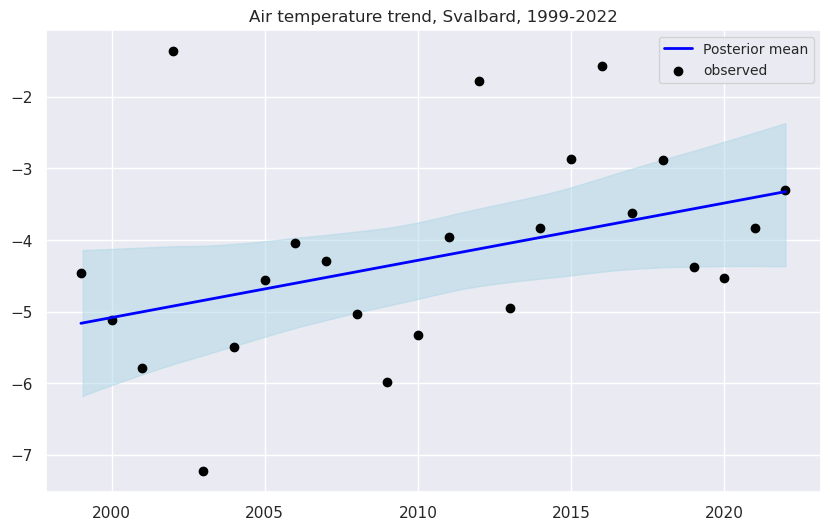

In [12]:
Tair_trend_model.predict(trend_idata, kind="pps")
ax2 = az.plot_hdi(x=bayelva_dataset_annual.year, y=trend_idata.posterior.Tair_mean,
                 color="lightblue", figsize=(10,6))
# ax.plot(bayelva_dataset_annual.year, trend_idata.posterior.Tair_mean.stack(samples=["chain","draw"]),
#         linewidth=1.0, color="lightblue", alpha=0.4)
ax2.plot(bayelva_dataset_annual.year, trend_idata.posterior.Tair_mean.mean(dim=["chain","draw"]),
        linewidth=2.0, color="blue", label="Posterior mean")
ax2.scatter(bayelva_dataset_annual.year, bayelva_dataset_annual.Tair, color="black", label="observed")
plt.legend(loc='best', prop={'size': 10})
plt.title("Air temperature trend, Svalbard, 1999-2022")
plt.show()

### Relating monthly soil and air temperatures

Now suppose we want to investigate the relationship between soil and air temperature.

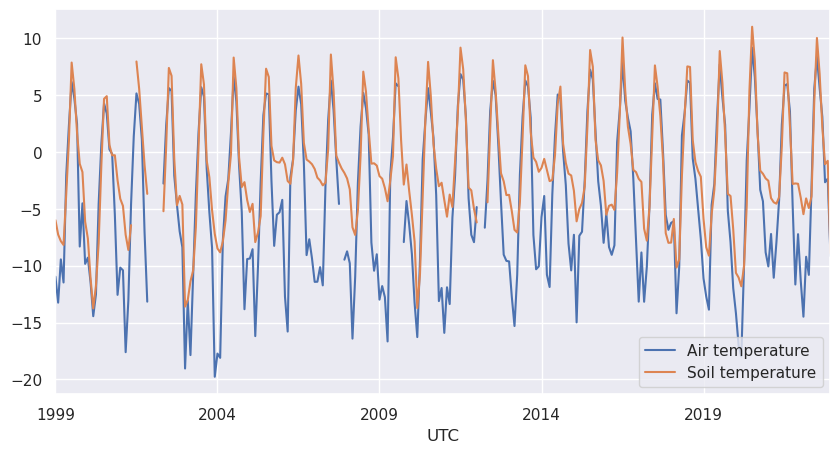

In [13]:
bayelva_dataset_monthly = bayelva_dataset.resample("1ME").agg(agg_ops) \
    .rename({"Tair_degC_200cm": "Tair", "Tsoil_degC_3cm": "Tsoil"}, axis=1)

plt.figure(figsize=(10,5))
bayelva_dataset_monthly.Tair.plot(label="Air temperature")
bayelva_dataset_monthly.Tsoil.plot(label="Soil temperature")
plt.legend(loc="lower right")
plt.show()

It's clear that soil temperature is very closely related to air temperature in the summer but becomes decoupled in the winter.

We know that this should be largely due to snow cover.

/tmp/ipykernel_263179/2621612757.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayelva_train["year"] = bayelva_train.index.year


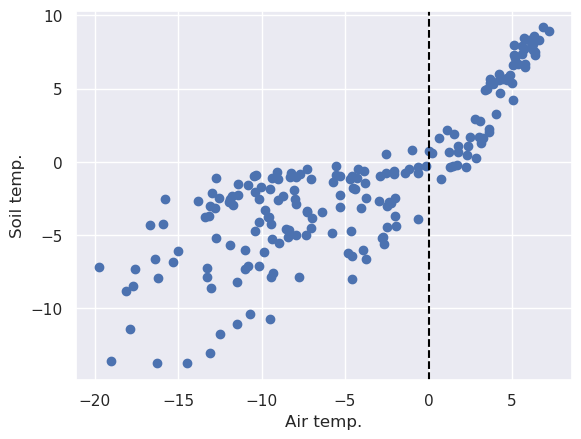

In [14]:
# select 1999-2015 as training period
bayelva_train = bayelva_dataset_monthly["1999":"2015"]
bayelva_train["year"] = bayelva_train.index.year
# get indices where both Tair and Tsoil are not missing
na_mask = (~bayelva_train.Tair.isna())*(~bayelva_train.Tsoil.isna())
plt.scatter(bayelva_train.Tair.loc[na_mask], bayelva_train.Tsoil.loc[na_mask]);
plt.axvline([0.0], color="black", linestyle="--")
plt.xlabel("Air temp.")
plt.ylabel("Soil temp.");

There is a clear change in the relationship around zero degrees since of course most snow-covered days have subzero temperatures.

Bearing this in mind, let's add a binary variable `is_freezing` that is true whenever air temperature is less than or equal to zero.

In [15]:
bayelva_train["is_freezing"] = bayelva_train.Tair <= 0

/tmp/ipykernel_263179/2663611640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayelva_train["is_freezing"] = bayelva_train.Tair <= 0


Now we can try to build a model.

The `(Tair|is_freezing)` syntax specifies a *group effect*. This will create separate regression coefficients for the two groups `is_freezing` and its negation.

In [16]:
model_Tsoil_Tair = bmb.Model("Tsoil ~ 1 + (Tair|is_freezing)", bayelva_train.loc[na_mask], family="t")
model_Tsoil_Tair

       Formula: Tsoil ~ 1 + (Tair|is_freezing)
        Family: t
          Link: mu = identity
  Observations: 193
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -1.4349, sigma: 12.6004)
        
        Group-level effects
            1|is_freezing ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 12.6004))
            Tair|is_freezing ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.7967))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.0402)
            nu ~ Gamma(alpha: 2.0, beta: 0.1)

Now let's fit the model. Note that this will take a few minutes.

In [17]:
Tsoil_monthly_idata = model_Tsoil_Tair.fit(draws=500, random_seed=1234, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tsoil_sigma, Tsoil_nu, Intercept, 1|is_freezing_sigma, 1|is_freezing_offset, Tair|is_freezing_sigma, Tair|is_freezing_offset]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 124 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Always pay attention to the warnings from the sampler! Divergent samples may indicate a potential problem with our model, or we may need to tweak the sampler settings.

In [18]:
# note that low ESS and high r_hat is a sign of poor convergence
az.summary(Tsoil_monthly_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|is_freezing[False],-0.010,2.405,-6.312,4.860,0.139,0.098,405.0,216.0,1.01
1|is_freezing[True],0.280,2.385,-4.316,6.712,0.137,0.097,405.0,235.0,1.01
1|is_freezing_sigma,3.366,4.078,0.001,11.712,0.202,0.143,415.0,494.0,1.01
Intercept,-1.335,2.400,-6.407,4.530,0.139,0.111,406.0,229.0,1.01
Tair|is_freezing[False],1.468,0.135,1.226,1.724,0.003,0.002,2136.0,1802.0,1.00
Tair|is_freezing[True],0.331,0.045,0.247,0.414,0.001,0.001,1544.0,993.0,1.00
Tair|is_freezing_sigma,1.435,0.683,0.491,2.681,0.027,0.019,525.0,778.0,1.01
Tsoil_nu,14.327,10.402,2.721,33.338,0.351,0.248,800.0,1244.0,1.00
Tsoil_sigma,2.114,0.171,1.774,2.416,0.006,0.004,951.0,991.0,1.00


In [19]:
def plot_predictions(data: pd.DataFrame, idata, title=""):
    na_mask_test = (~data.Tair.isna())*(~data.Tsoil.isna())
    model_Tsoil_Tair.predict(idata, data=data.loc[na_mask_test], kind="pps")
    # posterior predictive HDI
    ax = az.plot_hdi(x=data.loc[na_mask_test].index, y=idata.posterior_predictive.Tsoil, smooth=False, color="lightcoral", hdi_prob=0.95,
                    fill_kwargs={"label": "Posterior pred. 95% HDI", "alpha": 0.5}, figsize=(8,5))
    # posterior predicted mean HDI
    az.plot_hdi(x=data.loc[na_mask_test].index, y=idata.posterior.Tsoil_mean, ax=ax, smooth=False, color="sandybrown",
                fill_kwargs={"label": "Uncertainty in mean", "alpha": 0.7})
    # posterior predicted Tsoil mean
    ax.plot(data.loc[na_mask_test].index, idata.posterior.Tsoil_mean.mean(dim=["chain","draw"]), color="sandybrown", linewidth=2.0, label="Predicted mean")
    # observations
    ax.scatter(data.loc[na_mask_test].index, data.Tsoil.loc[na_mask_test], c="black", zorder=2, alpha=0.6, label="Observed")
    ax.legend()
    ax.set_title(title)
    return ax

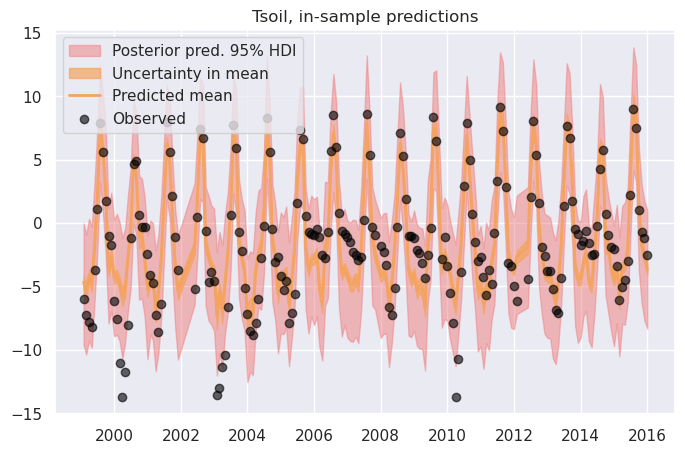

In [20]:
plot_predictions(bayelva_train, Tsoil_monthly_idata, title="Tsoil, in-sample predictions");

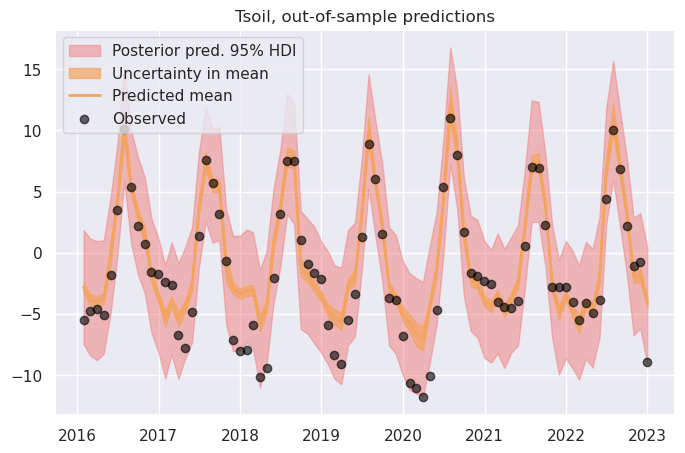

In [21]:
# generate out-of-sample predictions and plot them
bayelva_test = bayelva_dataset_monthly["2016":"2022"].copy()
bayelva_test["year"] = bayelva_test.index.year
bayelva_test["is_freezing"] = bayelva_dataset_monthly.Tair <= 0
ax = plot_predictions(bayelva_test, Tsoil_monthly_idata, "Tsoil, out-of-sample predictions")

While this is certainly not bad for a first attempt, there are some clear deficiencies. Note in particular the large posterior predictive spread in the winter, which indicates a large source of unexplained variance.

We are also currently ignoring the presence of missing values in the dataset.

### Multi-level modeling and automatic imputation of missing data

While `bambi` is a a very nice tool that lets us rapidly experiment with different configurations of GLMs, it has its limitations when trying to build more complex models, e.g. models involving multiple observed variables with hierarchical structure.

One key feature of `pymc` that `bambi` (currently) lacks is *automatic imputation* of missing data. A major advantage of Bayesian models is that **everything can be modeled as a random variable** and thus missing values can be seemlessly integrated out by sampling from their respective distributions.

We will try this out by re-implementing (and augmenting) the previous model directly in pymc.

In [22]:
import pytensor.tensor as pt

def Tsoil_monthly_model(data: pd.DataFrame):
    coords = {"time": data.index.values}
    # time indices
    time_idx = pt.arange(0, coords["time"].shape[0])
    # periodic sin and cos predictors
    periodic_predictors = pt.stack([pt.sin(2*pt.pi/12*time_idx), pt.cos(2*pt.pi/12*time_idx)])
    with pm.Model(coords=coords) as m:
        Tair_periodic_coef = pm.MvNormal("Tair_periodic_coef", pt.zeros(2), pt.eye(2))
        Tair_intercept = pm.Normal("Tair_intercept", 0, 10)
        Tair_trend = pm.Normal("Tair_trend", 0, 1)
        Tair_mean = pm.Deterministic("Tair_mean", Tair_intercept + Tair_trend*time_idx/12 + pt.matmul(periodic_predictors.T, Tair_periodic_coef))
        Tair_std = pm.Exponential("Tair_std", 1)
        Tair = pm.Normal("Tair", Tair_mean, Tair_std*pt.ones(Tair_mean.shape), observed=data.Tair.values, dims="time")
        is_freezing = pt.ones(Tair.shape[0])*(Tair <= 0)
        Tsoil_offset = pm.Normal("Tsoil_offset", 0, 10)
        Tsoil_Tair_mean = pm.Normal("Tsoil_Tair_mean", 0, 1)
        Tsoil_Tair_effects = pm.MvNormal("Tsoil_Tair", Tsoil_Tair_mean*pt.ones(2), pt.eye(2))
        Tsoil_Tair_predictors = pt.stack([Tair*is_freezing, Tair*(1-is_freezing)])
        Tsoil_mean = pm.Deterministic("Tsoil_mean", Tair_intercept + Tsoil_offset + pt.matmul(Tsoil_Tair_predictors.T, Tsoil_Tair_effects))
        Tsoil_std = pm.Exponential("Tsoil_std", 1.0)
        Tsoil = pm.Normal("Tsoil", Tsoil_mean, Tsoil_std*pt.ones(Tsoil_mean.shape), observed=data.Tsoil.values, dims="time")
    return m

/home/bgroenke/mambaforge/envs/bayes/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in Tair contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/bgroenke/mambaforge/envs/bayes/lib/python3.12/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in Tsoil contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


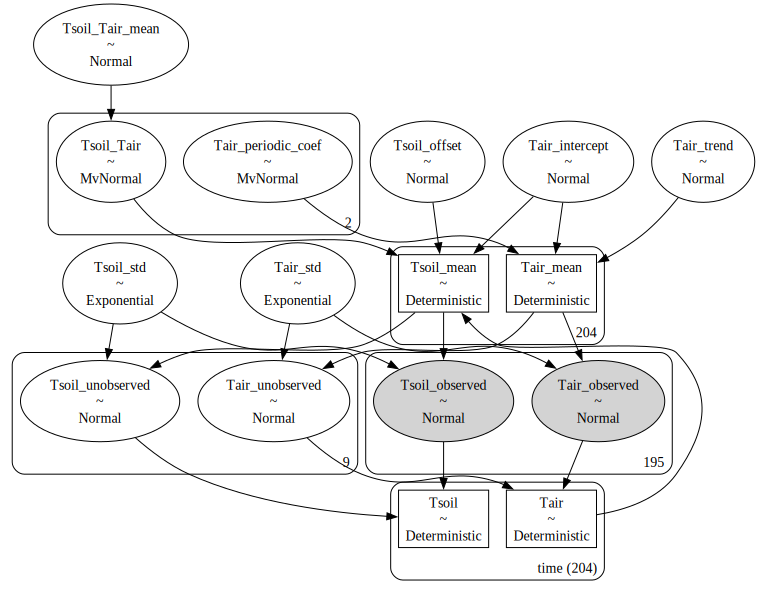

In [28]:
model = Tsoil_monthly_model(bayelva_train)
pm.model_to_graphviz(model)

Now let's fit the new model!

In [24]:
# fit the model using default NUTS sampler
with model:
    idata = pm.sample(draws=500, target_accept=0.95, random_seed=1234)
# print inference data summary for all free random variables
az.summary(idata, var_names=[var.name for var in model.free_RVs])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Tair_periodic_coef, Tair_intercept, Tair_trend, Tair_std, Tair_unobserved, Tsoil_offset, Tsoil_Tair_mean, Tsoil_Tair, Tsoil_std, Tsoil_unobserved]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 73 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Tair_periodic_coef[0],-1.947,0.308,-2.520,-1.379,0.006,0.004,2981.0,1381.0,1.0
Tair_periodic_coef[1],-7.715,0.303,-8.294,-7.165,0.006,0.004,2541.0,1427.0,1.0
Tair_intercept,-5.734,0.466,-6.614,-4.873,0.012,0.008,1582.0,1451.0,1.0
Tair_trend,0.110,0.047,0.023,0.198,0.001,0.001,1681.0,1453.0,1.0
Tair_std,3.230,0.162,2.945,3.546,0.003,0.002,2653.0,1470.0,1.0
Tair_unobserved[0],-11.087,3.398,-17.028,-4.196,0.064,0.045,2821.0,1599.0,1.0
Tair_unobserved[1],-13.223,3.207,-19.273,-7.593,0.068,0.049,2223.0,1534.0,1.0
Tair_unobserved[2],-13.130,3.330,-19.601,-7.256,0.064,0.045,2719.0,1443.0,1.0
Tair_unobserved[3],-10.946,3.188,-17.228,-5.390,0.063,0.045,2570.0,1793.0,1.0
Tair_unobserved[4],-7.405,3.343,-13.333,-1.182,0.064,0.047,2806.0,1186.0,1.0


We can generate predictions for the training period using `sample_posterior_predictive`. We will additionally plot the imputed months.

In [25]:
# sample posterior predictive for soil temperature;
# note that these predictions will still be conditioned on the observed air temperature.
pm.sample_posterior_predictive(idata, model, var_names=["Tsoil"], extend_inferencedata=True, random_seed=1234);

Sampling: [Tair_observed, Tsoil_observed, Tsoil_unobserved]


Output()

In [26]:
def plot_predictions_with_unobserved(data: pd.DataFrame, idata, hdi_prob=0.95):
    Tair_na = data.Tair.isna()
    Tsoil_na = data.Tsoil.isna()
    na_mask = np.logical_and(~Tair_na, ~Tsoil_na)
    # posterior predictive HDI
    ax = az.plot_hdi(x=data.index, y=idata.posterior_predictive.Tsoil, smooth=False, color="sandybrown", hdi_prob=hdi_prob,
                     fill_kwargs={"label": "Tsoil PP 95% HDI", "alpha": 0.3}, figsize=(12,8))
    ax.plot(data.index, idata.posterior.Tsoil_mean.mean(dim=["chain","draw"]), color="sandybrown", linewidth=2.0, label="Tsoil pred. mean")
    # posterior predicted Tair mean
    ax.plot(data.index, idata.posterior.Tair.mean(dim=["chain","draw"]), color="steelblue", linewidth=2.0, label="Air temperature")
    # imputed points
    Tair_unobs_hdi = az.hdi(idata.posterior.Tair_unobserved, hdi_prob=hdi_prob).Tair_unobserved
    Tair_unobs_mean = idata.posterior.Tair_unobserved.mean(dim=["chain", "draw"])
    ax.errorbar(data.loc[Tair_na].index, Tair_unobs_mean, np.abs(Tair_unobs_hdi - Tair_unobs_mean).T, c="steelblue", fmt="D", linewidth=2.0, alpha=0.9, capsize=4.0, label="Tair imputed")
    Tsoil_unobs_hdi = az.hdi(idata.posterior.Tsoil_unobserved, hdi_prob=hdi_prob).Tsoil_unobserved
    Tsoil_unobs_mean = idata.posterior.Tsoil_unobserved.mean(dim=["chain", "draw"])
    ax.errorbar(data.loc[Tsoil_na].index, Tsoil_unobs_mean, np.abs(Tsoil_unobs_hdi - Tsoil_unobs_mean).T, c="sandybrown", fmt="D", linewidth=2.0, alpha=0.9, capsize=4.0, label="Tsoil imputed")
    # observations
    # ax.scatter(data.loc[na_mask].index, data.Tair.loc[na_mask], c="blue", zorder=2, alpha=0.8, marker="o", label="Tair observed")
    ax.scatter(data.loc[na_mask].index, data.Tsoil.loc[na_mask], c="sandybrown", zorder=2, alpha=0.8, marker="o", label="Tsoil observed")
    ax.legend()
    return ax

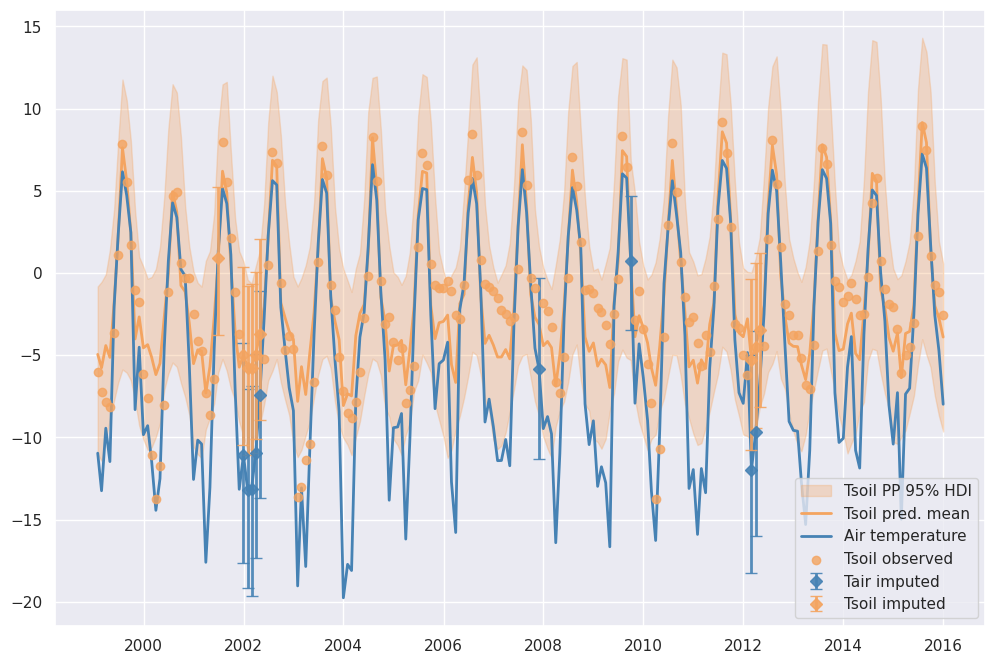

In [27]:
# note that there might be something off with the posterior predictive HDI of soil temperature here.
# It looks too regular given the air temperature inputs... this may be a bug in pymc posterior predictive sampling.
# needs further investigation!
plot_predictions_with_unobserved(bayelva_train, idata);

#### Exercises

1. How do you think we can improve this model? So far we have only used air and soil temperature, but perhaps you can find a way to use some of the other variables such as snow depth, precipitation, and radiation?

2. Try implementing an autoregressive version of this model for **daily values** using pymc's `AR` distribution. You could refer to [this example](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html) as a starting point.